In [1]:
library('transformeR')
library(raster)


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.1.3 (2021-08-04) is loaded


Get the latest stable version (2.1.5) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

Loading required package: sp



In [2]:
#archivosdf <- list.files(path = '../3.Datos generados/dataframes', pattern = "^df_grid_", full.names = TRUE)
#archivosdf
#archivos_grid <- list.files(path = '../1.Upscaling/upscaling_ba', full.names = TRUE)
archivos_raster <- list.files(path = '../3.Datos generados/raster', full.names = TRUE)
#archivos_raster

In [3]:
df_grid_25_sinInterpolar <- get(load('../3.Datos generados/dataframes/df_grid_25.Rdata'))

nearest neighbor

In [4]:
lista_variables <- c('grid_05','grid_1','grid_15','grid_2','grid_25','grid_3', 'grid_4','grid_5')
lista_df_interpoladas <- list()
for (i in 1:length(archivos_raster)){
    lista_interpoladas <- list()
    for (j in seq(1,9)){
        grid_raster <- raster(archivos_raster[i], band = j)  
        #creamos un raster vacío a 2.5
        grid_raster_2.5 <- raster(extent(grid_raster), res = 2.5)
        #realizamos interpolación por vecinos cercanos (ngb)
        raster_interp <- resample(grid_raster, grid_raster_2.5, method = "ngb")
        vector_raster_interp <- as.vector(raster_interp)
        columna = paste0('layer_',j)
        lista_interpoladas[[columna]] <- vector_raster_interp 
    }
    coordenadas_interpolada <- coordinates(raster_interp)
    df_interpoladas <- data.frame(lista_interpoladas)
    df_interpoladas <- cbind(coordenadas_interpolada, df_interpoladas)
    colnames(df_interpoladas) <- c('X','Y','FsOrNot','MainStart','MainEnd','SencondStart','SencondEnd','Length','C','P','FBA')
    var_name = paste0('df_interpoladas_',lista_variables[i])
    df_interpoladas = df_interpoladas[order(df_interpoladas$Y),]
    df_interpoladas = df_interpoladas[order(df_interpoladas$X),]
    lista_df_interpoladas[[var_name]] <- df_interpoladas
}

In [5]:
vector_grids <- c('grid_05','grid_1','grid_15','grid_2','grid_25','grid_3', 'grid_4','grid_5')
variablesComparar <- c('FsOrNot','MainStart','MainEnd','SencondStart','SencondEnd','Length','C','P','FBA')
lista_grids_MAES <- list()
for (i in 1:length(lista_df_interpoladas)){
    grid <- vector_grids[i]
    interpolada <- lista_df_interpoladas[[i]]
    MAE_s <- c()
    maxError <- c()
    for (var in variablesComparar){
        var_inter <- unlist(interpolada[var])
        names(var_inter) <- NULL
        var_grid_25_sinInterpolar <-unlist(df_grid_25_sinInterpolar[var])
        names(var_grid_25_sinInterpolar) <- NULL
        diff_var <- c()
        for (item in 1:length(var_inter)){
            if (is.na(var_inter[item]) & is.na(var_grid_25_sinInterpolar[item])){
                diff_var <- c(diff_var ,0)
            }else{
                diff_var <- c(diff_var, abs(var_inter[item] - var_grid_25_sinInterpolar[item]) )
            }
        }
    diff_var <- na.omit(diff_var) 
    MAE_s <- c(MAE_s, mean(diff_var))
    maxError <- c(maxError, max(diff_var))
    }
    MAE_s_normalizado <- MAE_s/maxError
    names(MAE_s_normalizado) <- variablesComparar
    if (vector_grids[i] == 'grid_25'){
        lista_grids_MAES[[vector_grids[i]]] <- MAE_s
    }else{
        lista_grids_MAES[[vector_grids[i]]] <- MAE_s_normalizado
    }
}

In [6]:
t(data.frame(lista_grids_MAES))

,FsOrNot,MainStart,MainEnd,SencondStart,SencondEnd,Length,C,P,FBA
grid_05,0.08940972,0.02927611,0.04016683,0.012811303,0.008345307,0.05781807,1.245030e-01,6.313878e-02,4.318236e-02
grid_1,0.05304784,0.01911147,0.03625993,0.005383580,0.003545916,0.04058306,6.243892e-02,4.736081e-02,4.049946e-02
grid_15,0.03288966,0.01345368,0.02945048,0.005130028,0.004135949,0.02976408,4.377659e-02,3.603289e-02,4.236243e-02
grid_2,0.02662037,0.01071956,0.02362808,0.004345190,0.003410469,0.02546572,3.717047e-02,3.330795e-02,3.650922e-02
grid_25,0.00000000,0.00000000,0.00000000,0.000000000,0.000000000,0.00000000,3.320233e-09,4.942823e-09,3.847228e-09
grid_3,0.03182870,0.01283305,0.02850984,0.005653458,0.003985433,0.03183458,4.608705e-02,4.157228e-02,4.257019e-02
grid_4,0.04812886,0.01627686,0.03613703,0.006307115,0.004907292,0.04126276,6.190737e-02,5.174731e-02,4.595209e-02
grid_5,0.06172840,0.01720432,0.03901577,0.006273058,0.004410926,0.03910362,7.110289e-02,5.548743e-02,6.296611e-02


In [7]:
library(xtable)
table <- xtable(t(data.frame(lista_grids_MAES)))
print(table, include.rownames = FALSE)

% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Thu Sep 28 16:18:17 2023
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrrrr}
  \hline
FsOrNot & MainStart & MainEnd & SencondStart & SencondEnd & Length & C & P & FBA \\ 
  \hline
0.09 & 0.03 & 0.04 & 0.01 & 0.01 & 0.06 & 0.12 & 0.06 & 0.04 \\ 
  0.05 & 0.02 & 0.04 & 0.01 & 0.00 & 0.04 & 0.06 & 0.05 & 0.04 \\ 
  0.03 & 0.01 & 0.03 & 0.01 & 0.00 & 0.03 & 0.04 & 0.04 & 0.04 \\ 
  0.03 & 0.01 & 0.02 & 0.00 & 0.00 & 0.03 & 0.04 & 0.03 & 0.04 \\ 
  0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\ 
  0.03 & 0.01 & 0.03 & 0.01 & 0.00 & 0.03 & 0.05 & 0.04 & 0.04 \\ 
  0.05 & 0.02 & 0.04 & 0.01 & 0.00 & 0.04 & 0.06 & 0.05 & 0.05 \\ 
  0.06 & 0.02 & 0.04 & 0.01 & 0.00 & 0.04 & 0.07 & 0.06 & 0.06 \\ 
   \hline
\end{tabular}
\end{table}


### Visualizaciones

In [9]:
vector_grids <- c('grid_05','grid_2','grid_3','grid_5')
variablesComparar <- c('Length','C','P')
lista_df_interpoladas_viz <- list(lista_df_interpoladas$'df_interpoladas_grid_05', lista_df_interpoladas$'df_interpoladas_grid_2', lista_df_interpoladas$'df_interpoladas_grid_3', lista_df_interpoladas$'df_interpoladas_grid_5')
lista_grids <- list()
for (i in 1:length(lista_df_interpoladas_viz)){
    grid <- vector_grids[i]
    interpolada <- lista_df_interpoladas_viz[[i]]
    diff_list <- list()
    for (var in variablesComparar){
        var_inter <- unlist(interpolada[var])
        var_grid_25_sinInterpolar <-unlist(lista_df_interpoladas$'df_interpoladas_grid_25'[var])
        MainStart <- unlist(interpolada['MainStart'])
        names(var_inter) <- NULL
        names(var_grid_25_sinInterpolar) <- NULL
        #names(fba) <- NULL
        diff_var <- c()
        for (item in 1:length(var_inter)){
            if (is.na(MainStart[item])){
                diff_var <- c(diff_var ,NA)
            }else{
                diff_var <- c(diff_var, abs(var_inter[item] - var_grid_25_sinInterpolar[item]) )
            }
        }
    #diff_var <- na.omit(diff_var) 
    diff_list[[var]] <- diff_var
    
    }
    lista_grids[[vector_grids[i]]] <- diff_list
}

In [10]:
library("visualizeR")

quantity2clim <- function(quantity, what, ref.grid, backperm = NULL) {
  if(!is.null(backperm)){quantity <- quantity[backperm]}
  mat <- matrix(quantity, nrow = 1)  
  ref.grid$Data <- mat2Dto3Darray(mat, x = ref.grid$xyCoords$x , y = ref.grid$xyCoords$y)
  attr(ref.grid$Data, "climatology:fun") <- what
  return(ref.grid)
}


Warning message:
“no DISPLAY variable so Tk is not available”
visualizeR version 1.6.1 (2021-03-11) is loaded


Get the latest stable version (1.6.3) using <devtools::install_github('SantanderMetGroup/visualizeR')>

Please see 'citation("visualizeR")' to cite this package.



In [11]:
grid_25 <- get(load('../1.Upscaling/upscaling_ba/ba_grid_25.Rdata'))

In [12]:
MAE_C_clim05 <- quantity2clim(quantity = lista_grids$grid_05$C, what = 'MAE_s0C', ref.grid = grid_25, backperm = NULL)
MAE_P_clim05 <- quantity2clim(quantity = lista_grids$grid_05$P, what = 'MAE_s0P', ref.grid = grid_25, backperm = NULL)
MAE_L_clim05 <- quantity2clim(quantity = lista_grids$grid_05$Length, what = 'MAE_s0L', ref.grid = grid_25, backperm = NULL)

MAE_C_clim5 <- quantity2clim(quantity = lista_grids$grid_5$C, what = 'MAE_sC', ref.grid = grid_25, backperm = NULL)
MAE_P_clim5 <- quantity2clim(quantity = lista_grids$grid_5$P, what = 'MAE_sP', ref.grid = grid_25, backperm = NULL)
MAE_L_clim5 <- quantity2clim(quantity = lista_grids$grid_5$Length, what = 'MAE_sL', ref.grid = grid_25, backperm = NULL)

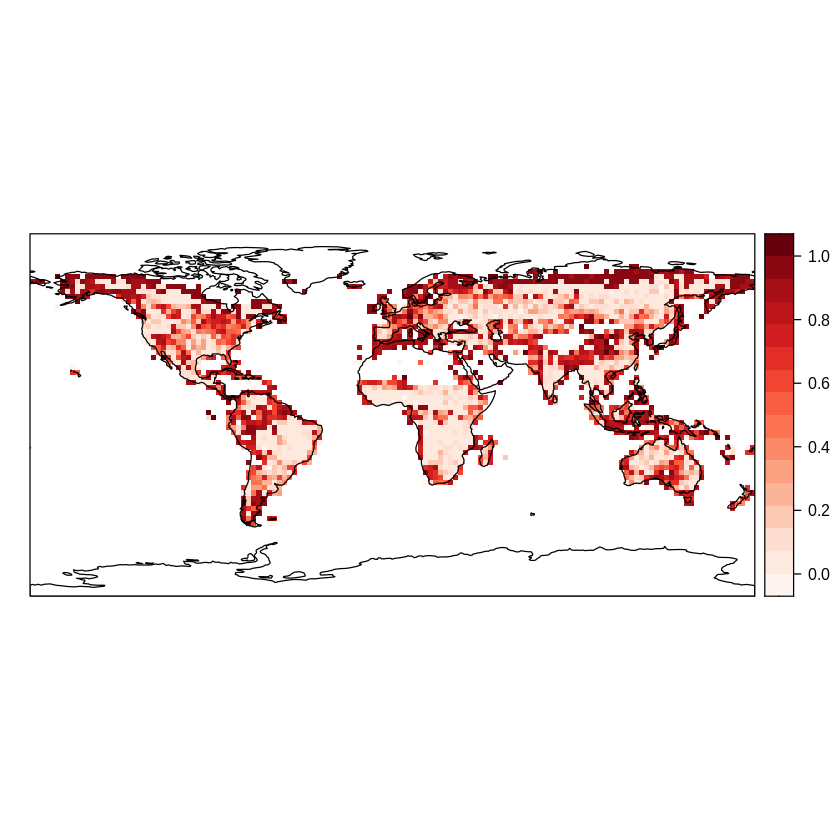

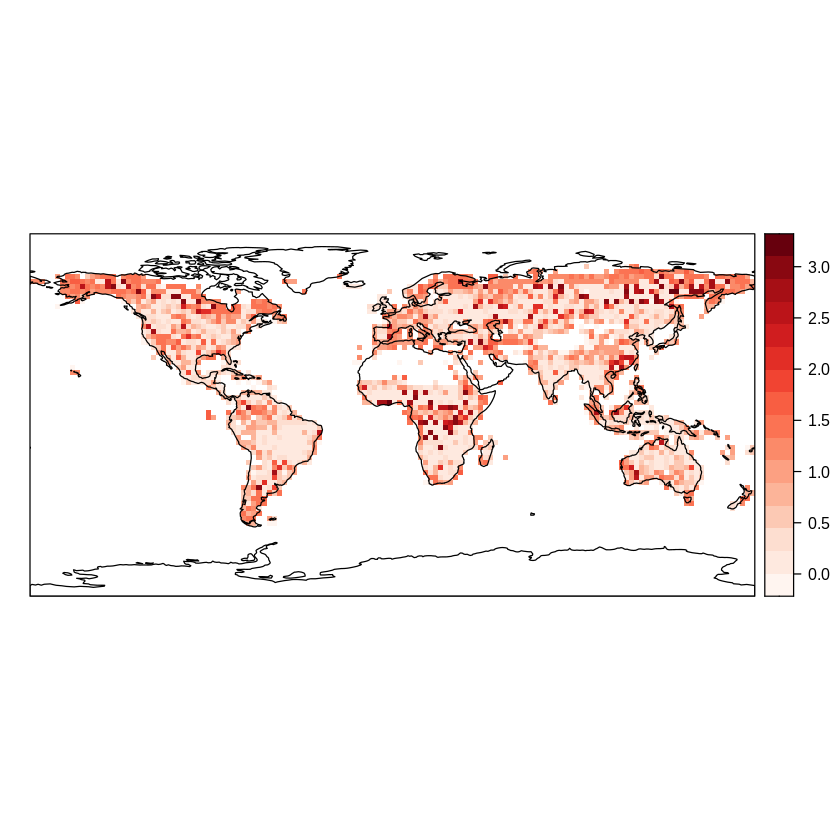

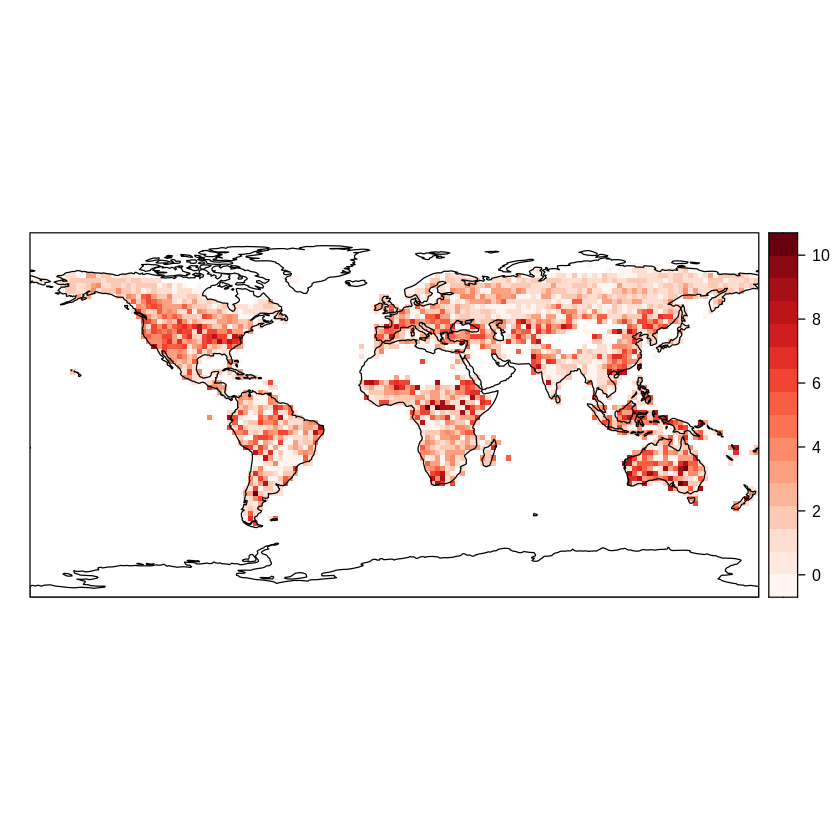

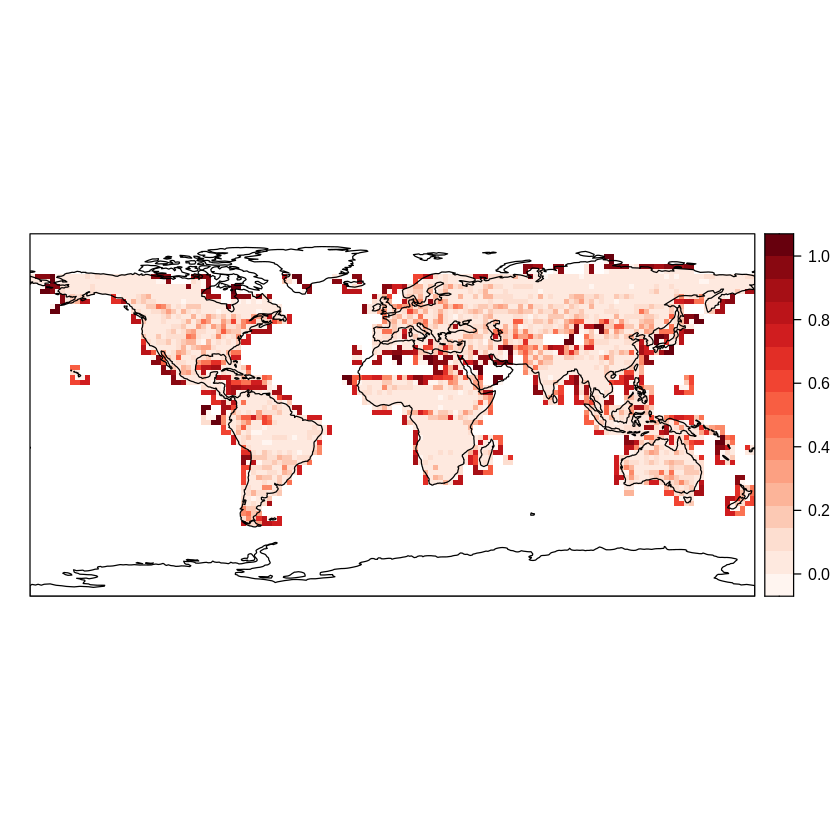

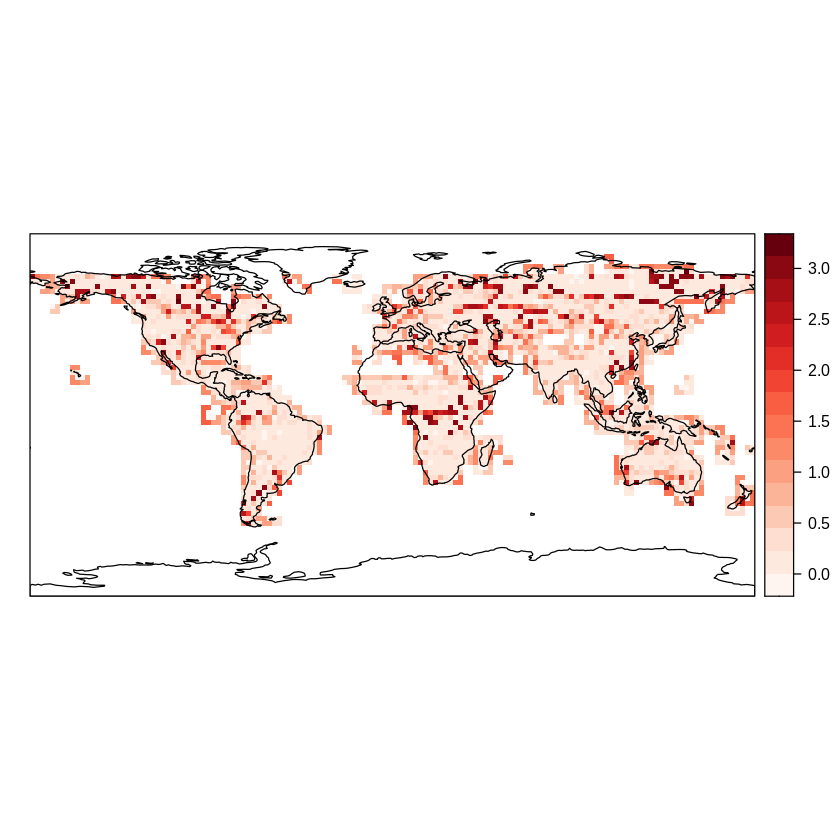

png 
  2

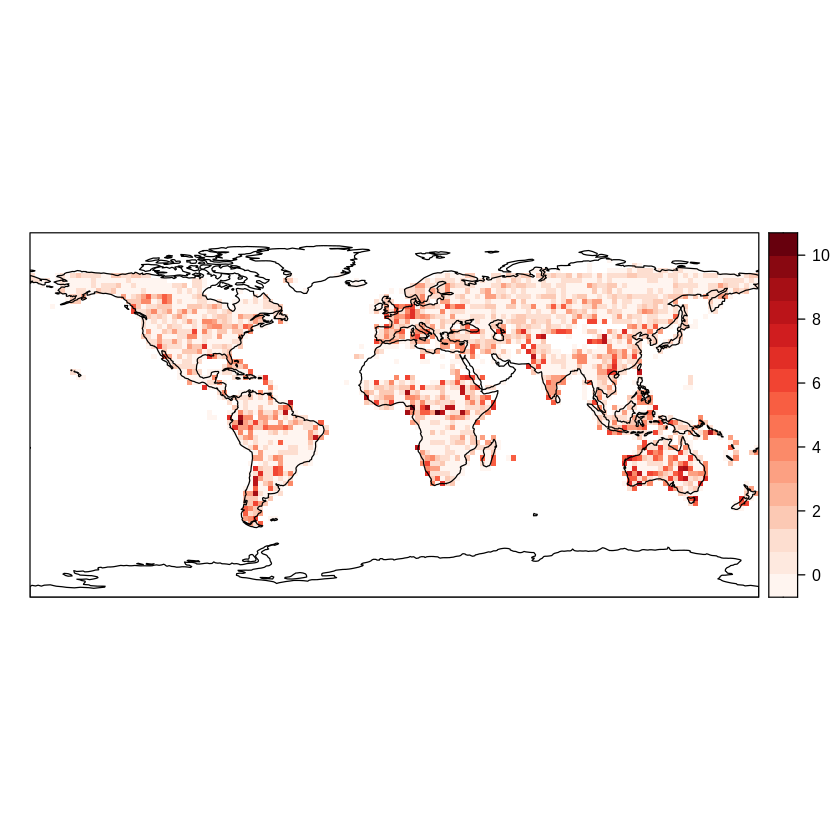

In [13]:
fig_MAE_C_clim05 <- spatialPlot(MAE_C_clim05,backdrop.theme = 'coastline',color.theme = "Reds")
fig_MAE_P_clim05 <- spatialPlot(MAE_P_clim05,backdrop.theme = 'coastline',color.theme = "Reds")
fig_MAE_L_clim05 <- spatialPlot(MAE_L_clim05,backdrop.theme = 'coastline',color.theme = "Reds")

fig_MAE_C_clim5 <- spatialPlot(MAE_C_clim5,backdrop.theme = 'coastline',color.theme = "Reds")
fig_MAE_P_clim5 <- spatialPlot(MAE_P_clim5,backdrop.theme = 'coastline',color.theme = "Reds")
fig_MAE_L_clim5 <- spatialPlot(MAE_L_clim5,backdrop.theme = 'coastline',color.theme = "Reds")

fig_MAE_C_clim05
fig_MAE_P_clim05
fig_MAE_L_clim05
fig_MAE_C_clim5
fig_MAE_P_clim5
fig_MAE_L_clim5

plotname <- "interpolacion.pdf"
pdf(plotname)
fig_MAE_C_clim05
fig_MAE_P_clim05
fig_MAE_L_clim05
fig_MAE_C_clim5
fig_MAE_P_clim5
fig_MAE_L_clim5
dev.off()